# Modelo

Mismo modelo que v01 pero uso el dataset al que le elimine las variables con data drifting (cprestamos_personales y mprestamos_personales) y entreno solo sobre abril.
Si quisiera hacer backtesting podria entrenar solo con marzo y testear en abril, o bien separar el 20% del dataset total o algo asi.


In [3]:
# %pip install scikit-learn==1.3.2
# %pip install seaborn==0.13.1
# %pip install numpy==1.26.4
# %pip install matplotlib==3.7.1
# %pip install pandas==2.1.4
# %pip install lightgbm==4.4.0
# %pip install optuna==3.6.1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [2]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe_v02.csv'
# dataset_file = 'competencia_01_fe.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

data = pd.read_csv(dataset_path + dataset_file)

In [3]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [4]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

# Optimizacion

In [5]:
meses_train = [202104]

In [6]:
train_data = data[data['foto_mes'].isin(meses_train)]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

In [ ]:
# No imputo nulos porque el modelo los maneja

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Xif = imp_mean.fit_transform(X_test)

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [7]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelo.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [8]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [9]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

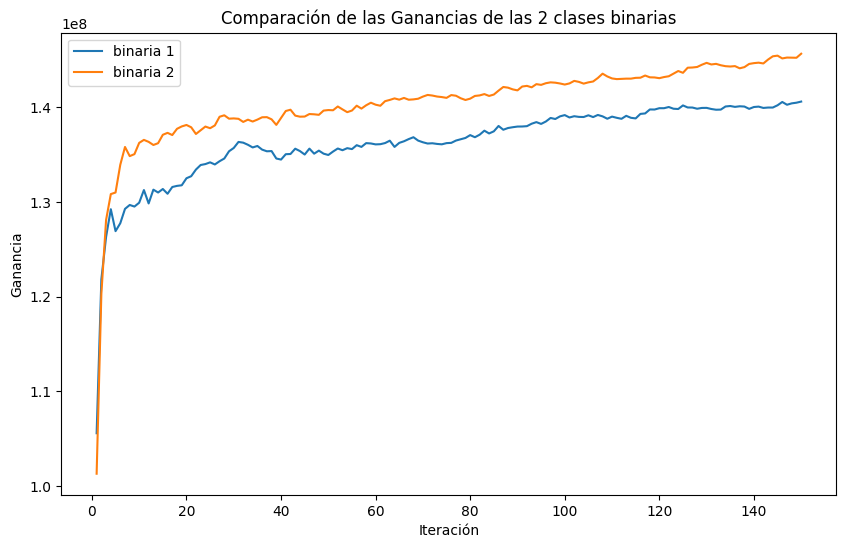

In [10]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [12]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100), # segun statquest esto deberia ir de 8 a 32
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    
    # print(f"Learning Rate: {learning_rate}, Type: {type(learning_rate)}")
    
    # Use callbacks for early stopping
    early_stopping_cb = lgb.early_stopping(stopping_rounds=50) # creo que en min_delta le tendria que pasar un parametro con la ganancia que considero irrelevante
        
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior (ahora le puso 100 para mostrarnos, pero hay que ponerle un numero alto, 10.000, 200.000)
        # early_stopping_rounds= int((50 + 5) / learning_rate), # (ale dijo que lo mas comun es que sea 1/learning rate)
        # early_stopping_rounds = 50,
        callbacks=[early_stopping_cb],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5

In [13]:
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm_v03" # UPDATE

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

DuplicatedStudyError: Another study with name 'exp_301_lgbm' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [25]:
study.optimize(objective, n_trials=100)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[724]	cv_agg's valid gan_eval: 5.49808e+07 + 3.94516e+06


[I 2024-10-06 10:46:41,892] Trial 1 finished with value: 274904000.0 and parameters: {'num_leaves': 23, 'learning_rate': 0.03687019278875851, 'min_data_in_leaf': 481, 'feature_fraction': 0.34260836216626794, 'bagging_fraction': 0.3916828795580931}. Best is trial 1 with value: 274904000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	cv_agg's valid gan_eval: 5.40232e+07 + 3.94801e+06


[I 2024-10-06 10:47:54,017] Trial 2 finished with value: 270116000.0 and parameters: {'num_leaves': 42, 'learning_rate': 0.025901878908012134, 'min_data_in_leaf': 986, 'feature_fraction': 0.9851621736705217, 'bagging_fraction': 0.6217574595473296}. Best is trial 1 with value: 274904000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[601]	cv_agg's valid gan_eval: 5.59748e+07 + 4.12703e+06


[I 2024-10-06 10:50:01,655] Trial 3 finished with value: 279874000.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.04605650185562476, 'min_data_in_leaf': 132, 'feature_fraction': 0.699472062076442, 'bagging_fraction': 0.49819289850274506}. Best is trial 3 with value: 279874000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	cv_agg's valid gan_eval: 5.37292e+07 + 3.68895e+06


[I 2024-10-06 10:51:44,554] Trial 4 finished with value: 268646000.0 and parameters: {'num_leaves': 20, 'learning_rate': 0.04978658255509438, 'min_data_in_leaf': 167, 'feature_fraction': 0.30323597045059936, 'bagging_fraction': 0.7408717273361372}. Best is trial 3 with value: 279874000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[872]	cv_agg's valid gan_eval: 5.30796e+07 + 4.20325e+06


[I 2024-10-06 10:53:52,467] Trial 5 finished with value: 265398000.0 and parameters: {'num_leaves': 21, 'learning_rate': 0.013181709027800241, 'min_data_in_leaf': 827, 'feature_fraction': 0.8608700021625904, 'bagging_fraction': 0.7266548865687485}. Best is trial 3 with value: 279874000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[864]	cv_agg's valid gan_eval: 5.13996e+07 + 4.40458e+06


[I 2024-10-06 10:55:56,784] Trial 6 finished with value: 256998000.0 and parameters: {'num_leaves': 13, 'learning_rate': 0.010681127041726942, 'min_data_in_leaf': 466, 'feature_fraction': 0.7332073625230885, 'bagging_fraction': 0.801747290969927}. Best is trial 3 with value: 279874000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[581]	cv_agg's valid gan_eval: 5.59944e+07 + 4.19295e+06


[I 2024-10-06 10:58:52,648] Trial 7 finished with value: 279972000.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.025683550374152944, 'min_data_in_leaf': 48, 'feature_fraction': 0.4591342073152662, 'bagging_fraction': 0.7176479620284673}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	cv_agg's valid gan_eval: 5.5804e+07 + 3.41965e+06


[I 2024-10-06 11:03:04,204] Trial 8 finished with value: 279020000.0 and parameters: {'num_leaves': 55, 'learning_rate': 0.016616812403286215, 'min_data_in_leaf': 957, 'feature_fraction': 0.535986676978974, 'bagging_fraction': 0.8595032027419701}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	cv_agg's valid gan_eval: 5.43088e+07 + 3.94473e+06


[I 2024-10-06 11:03:55,429] Trial 9 finished with value: 271544000.0 and parameters: {'num_leaves': 65, 'learning_rate': 0.03479498535187211, 'min_data_in_leaf': 178, 'feature_fraction': 0.8141838312552648, 'bagging_fraction': 0.5058631877670404}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[863]	cv_agg's valid gan_eval: 5.58726e+07 + 3.9519e+06


[I 2024-10-06 11:07:45,995] Trial 10 finished with value: 279363000.0 and parameters: {'num_leaves': 59, 'learning_rate': 0.022712266075493877, 'min_data_in_leaf': 163, 'feature_fraction': 0.7028639326021757, 'bagging_fraction': 0.40591454326390175}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[976]	cv_agg's valid gan_eval: 5.48254e+07 + 4.66394e+06


[I 2024-10-06 11:11:07,511] Trial 11 finished with value: 274127000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.005069481320057006, 'min_data_in_leaf': 678, 'feature_fraction': 0.15389265907024025, 'bagging_fraction': 0.10185144525984569}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[559]	cv_agg's valid gan_eval: 5.53392e+07 + 3.08437e+06


[I 2024-10-06 11:14:19,631] Trial 12 finished with value: 276696000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.04990586838519949, 'min_data_in_leaf': 2, 'feature_fraction': 0.5592345340523734, 'bagging_fraction': 0.9736630578873153}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[389]	cv_agg's valid gan_eval: 5.59034e+07 + 4.02067e+06


[I 2024-10-06 11:16:37,921] Trial 13 finished with value: 279517000.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.03786528592891099, 'min_data_in_leaf': 314, 'feature_fraction': 0.5259619187958247, 'bagging_fraction': 0.5668984029875714}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[381]	cv_agg's valid gan_eval: 5.36522e+07 + 3.68915e+06


[I 2024-10-06 11:18:31,080] Trial 14 finished with value: 268261000.0 and parameters: {'num_leaves': 41, 'learning_rate': 0.031536383500606655, 'min_data_in_leaf': 2, 'feature_fraction': 0.3985106894155363, 'bagging_fraction': 0.24913147148241027}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	cv_agg's valid gan_eval: 5.4649e+07 + 3.66123e+06


[I 2024-10-06 11:19:54,033] Trial 15 finished with value: 273245000.0 and parameters: {'num_leaves': 42, 'learning_rate': 0.04201314593090696, 'min_data_in_leaf': 327, 'feature_fraction': 0.6339114180829248, 'bagging_fraction': 0.40853210860738165}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	cv_agg's valid gan_eval: 5.47848e+07 + 4.54563e+06


[I 2024-10-06 11:21:49,861] Trial 16 finished with value: 273924000.0 and parameters: {'num_leaves': 76, 'learning_rate': 0.01898063076744643, 'min_data_in_leaf': 307, 'feature_fraction': 0.4468418996862048, 'bagging_fraction': 0.6495997341252947}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[468]	cv_agg's valid gan_eval: 5.42304e+07 + 4.33516e+06


[I 2024-10-06 11:23:31,925] Trial 17 finished with value: 271152000.0 and parameters: {'num_leaves': 33, 'learning_rate': 0.02826067087976431, 'min_data_in_leaf': 103, 'feature_fraction': 0.24309913548123668, 'bagging_fraction': 0.9175436732183355}. Best is trial 7 with value: 279972000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[464]	cv_agg's valid gan_eval: 5.68148e+07 + 3.98985e+06


[I 2024-10-06 11:25:58,842] Trial 18 finished with value: 284074000.0 and parameters: {'num_leaves': 68, 'learning_rate': 0.04359141581571475, 'min_data_in_leaf': 625, 'feature_fraction': 0.6424926947612404, 'bagging_fraction': 0.49730869627627244}. Best is trial 18 with value: 284074000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[329]	cv_agg's valid gan_eval: 5.53028e+07 + 4.35319e+06


[I 2024-10-06 11:27:12,247] Trial 19 finished with value: 276514000.0 and parameters: {'num_leaves': 68, 'learning_rate': 0.031638217135491295, 'min_data_in_leaf': 642, 'feature_fraction': 0.10396347747360923, 'bagging_fraction': 0.2712190999817227}. Best is trial 18 with value: 284074000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	cv_agg's valid gan_eval: 5.5818e+07 + 3.14526e+06


[I 2024-10-06 11:29:24,131] Trial 20 finished with value: 279090000.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.041966719413361525, 'min_data_in_leaf': 681, 'feature_fraction': 0.4385489757550916, 'bagging_fraction': 0.7144387220431442}. Best is trial 18 with value: 284074000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[543]	cv_agg's valid gan_eval: 5.71858e+07 + 4.0482e+06


[I 2024-10-06 11:32:54,510] Trial 21 finished with value: 285929000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.02366240583155849, 'min_data_in_leaf': 583, 'feature_fraction': 0.6113096329613821, 'bagging_fraction': 0.6165023515932839}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[527]	cv_agg's valid gan_eval: 5.7127e+07 + 3.71767e+06


[I 2024-10-06 11:36:52,787] Trial 22 finished with value: 285635000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.023605524231665512, 'min_data_in_leaf': 593, 'feature_fraction': 0.6093636132754094, 'bagging_fraction': 0.6241624516422372}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	cv_agg's valid gan_eval: 5.44908e+07 + 3.8819e+06


[I 2024-10-06 11:38:31,038] Trial 23 finished with value: 272454000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.021137285008593163, 'min_data_in_leaf': 607, 'feature_fraction': 0.6228912435430687, 'bagging_fraction': 0.5900846952893218}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	cv_agg's valid gan_eval: 5.6014e+07 + 4.2003e+06


[I 2024-10-06 11:40:11,975] Trial 24 finished with value: 280070000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.029487990002023158, 'min_data_in_leaf': 565, 'feature_fraction': 0.7999440983379348, 'bagging_fraction': 0.4874940291929136}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	cv_agg's valid gan_eval: 5.52398e+07 + 4.10392e+06


[I 2024-10-06 11:42:49,127] Trial 25 finished with value: 276199000.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.0228223739387212, 'min_data_in_leaf': 779, 'feature_fraction': 0.6055902293256642, 'bagging_fraction': 0.3252734457323325}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	cv_agg's valid gan_eval: 5.43312e+07 + 4.2333e+06


[I 2024-10-06 11:44:06,778] Trial 26 finished with value: 271656000.0 and parameters: {'num_leaves': 79, 'learning_rate': 0.015344269969766022, 'min_data_in_leaf': 412, 'feature_fraction': 0.9384371233346316, 'bagging_fraction': 0.6546414202032724}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	cv_agg's valid gan_eval: 5.60168e+07 + 4.17233e+06


[I 2024-10-06 11:46:33,735] Trial 27 finished with value: 280084000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.02477868995974543, 'min_data_in_leaf': 798, 'feature_fraction': 0.6758755016121467, 'bagging_fraction': 0.5407596147801558}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[362]	cv_agg's valid gan_eval: 5.586e+07 + 4.14385e+06


[I 2024-10-06 11:48:16,158] Trial 28 finished with value: 279300000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.01813548840792823, 'min_data_in_leaf': 568, 'feature_fraction': 0.7924639937450465, 'bagging_fraction': 0.8112527970162065}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	cv_agg's valid gan_eval: 5.63766e+07 + 3.92885e+06


[I 2024-10-06 11:50:45,242] Trial 29 finished with value: 281883000.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.03258434782852958, 'min_data_in_leaf': 731, 'feature_fraction': 0.524505827891858, 'bagging_fraction': 0.4270873514153451}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	cv_agg's valid gan_eval: 5.5601e+07 + 3.48825e+06


[I 2024-10-06 11:52:14,871] Trial 30 finished with value: 278005000.0 and parameters: {'num_leaves': 69, 'learning_rate': 0.03816015153011518, 'min_data_in_leaf': 497, 'feature_fraction': 0.7464759911718915, 'bagging_fraction': 0.3500524131478346}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[739]	cv_agg's valid gan_eval: 5.56318e+07 + 4.02261e+06


[I 2024-10-06 11:57:32,055] Trial 31 finished with value: 278159000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.009780863375807157, 'min_data_in_leaf': 871, 'feature_fraction': 0.586988975210106, 'bagging_fraction': 0.4554248416422403}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	cv_agg's valid gan_eval: 5.59076e+07 + 3.90254e+06


[I 2024-10-06 11:59:42,072] Trial 32 finished with value: 279538000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.03377120178688856, 'min_data_in_leaf': 729, 'feature_fraction': 0.48006750531474873, 'bagging_fraction': 0.4354815214035745}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	cv_agg's valid gan_eval: 5.62856e+07 + 3.77636e+06


[I 2024-10-06 12:02:04,589] Trial 33 finished with value: 281428000.0 and parameters: {'num_leaves': 83, 'learning_rate': 0.04187204258901503, 'min_data_in_leaf': 555, 'feature_fraction': 0.5161775087900593, 'bagging_fraction': 0.5933398278995952}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	cv_agg's valid gan_eval: 5.6455e+07 + 3.75736e+06


[I 2024-10-06 12:04:41,459] Trial 34 finished with value: 282275000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.04519465008690731, 'min_data_in_leaf': 729, 'feature_fraction': 0.6441307025160447, 'bagging_fraction': 0.641987732712773}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	cv_agg's valid gan_eval: 5.59258e+07 + 3.65071e+06


[I 2024-10-06 12:06:11,848] Trial 35 finished with value: 279629000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.045955647147721365, 'min_data_in_leaf': 437, 'feature_fraction': 0.6525231541945238, 'bagging_fraction': 0.6573549666251434}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	cv_agg's valid gan_eval: 5.57088e+07 + 4.00019e+06


[I 2024-10-06 12:07:43,342] Trial 36 finished with value: 278544000.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.046183217670509, 'min_data_in_leaf': 906, 'feature_fraction': 0.6836339460337089, 'bagging_fraction': 0.5384598185839118}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	cv_agg's valid gan_eval: 5.4012e+07 + 4.14877e+06


[I 2024-10-06 12:08:42,223] Trial 37 finished with value: 270060000.0 and parameters: {'num_leaves': 50, 'learning_rate': 0.044980292454476524, 'min_data_in_leaf': 628, 'feature_fraction': 0.3673102368469634, 'bagging_fraction': 0.6255743413835329}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	cv_agg's valid gan_eval: 5.57452e+07 + 3.41827e+06


[I 2024-10-06 12:10:26,764] Trial 38 finished with value: 278726000.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.026855319916737938, 'min_data_in_leaf': 719, 'feature_fraction': 0.9142755970537808, 'bagging_fraction': 0.7607795679429211}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	cv_agg's valid gan_eval: 5.44922e+07 + 4.64024e+06


[I 2024-10-06 12:11:28,878] Trial 39 finished with value: 272461000.0 and parameters: {'num_leaves': 32, 'learning_rate': 0.048125905577297755, 'min_data_in_leaf': 530, 'feature_fraction': 0.7483438010571353, 'bagging_fraction': 0.6892955451820109}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[575]	cv_agg's valid gan_eval: 5.19344e+07 + 4.40031e+06


[I 2024-10-06 12:13:13,707] Trial 40 finished with value: 259672000.0 and parameters: {'num_leaves': 8, 'learning_rate': 0.039371266209376296, 'min_data_in_leaf': 402, 'feature_fraction': 0.5765657744950998, 'bagging_fraction': 0.7847382269796979}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	cv_agg's valid gan_eval: 5.45566e+07 + 4.56223e+06


[I 2024-10-06 12:14:14,095] Trial 41 finished with value: 272783000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.03558171481426641, 'min_data_in_leaf': 472, 'feature_fraction': 0.7427585046637862, 'bagging_fraction': 0.49914780481879123}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	cv_agg's valid gan_eval: 5.58348e+07 + 4.04477e+06


[I 2024-10-06 12:16:17,863] Trial 42 finished with value: 279174000.0 and parameters: {'num_leaves': 88, 'learning_rate': 0.02389198289591587, 'min_data_in_leaf': 738, 'feature_fraction': 0.4924578161173134, 'bagging_fraction': 0.5996893723904961}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[393]	cv_agg's valid gan_eval: 5.6084e+07 + 4.03508e+06


[I 2024-10-06 12:18:48,203] Trial 43 finished with value: 280420000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.03061618108833815, 'min_data_in_leaf': 838, 'feature_fraction': 0.5584400512589406, 'bagging_fraction': 0.3647154667099881}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	cv_agg's valid gan_eval: 5.6035e+07 + 3.92344e+06


[I 2024-10-06 12:20:42,654] Trial 44 finished with value: 280175000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.04419566788665435, 'min_data_in_leaf': 674, 'feature_fraction': 0.6392005582902092, 'bagging_fraction': 0.45279451497344547}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[504]	cv_agg's valid gan_eval: 5.5419e+07 + 4.00014e+06


[I 2024-10-06 12:22:47,191] Trial 45 finished with value: 277095000.0 and parameters: {'num_leaves': 59, 'learning_rate': 0.02110729055951812, 'min_data_in_leaf': 600, 'feature_fraction': 0.7051203403085509, 'bagging_fraction': 0.5414208547208574}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	cv_agg's valid gan_eval: 5.5307e+07 + 3.77943e+06


[I 2024-10-06 12:25:11,912] Trial 46 finished with value: 276535000.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.040352191225426506, 'min_data_in_leaf': 774, 'feature_fraction': 0.5944866987300106, 'bagging_fraction': 0.6953407437926533}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	cv_agg's valid gan_eval: 5.68064e+07 + 4.03488e+06


[I 2024-10-06 12:26:37,544] Trial 47 finished with value: 284032000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.04784403481029136, 'min_data_in_leaf': 669, 'feature_fraction': 0.8564791880403279, 'bagging_fraction': 0.8359711245493441}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	cv_agg's valid gan_eval: 5.68148e+07 + 3.48193e+06


[I 2024-10-06 12:28:16,180] Trial 48 finished with value: 284074000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.0474629023242596, 'min_data_in_leaf': 647, 'feature_fraction': 0.9613506242156978, 'bagging_fraction': 0.8958506328909897}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	cv_agg's valid gan_eval: 5.54428e+07 + 3.98743e+06


[I 2024-10-06 12:29:28,061] Trial 49 finished with value: 277214000.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.04891071404146999, 'min_data_in_leaf': 512, 'feature_fraction': 0.9923662043799417, 'bagging_fraction': 0.8932484343417186}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	cv_agg's valid gan_eval: 5.66034e+07 + 4.08296e+06


[I 2024-10-06 12:30:49,255] Trial 50 finished with value: 283017000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.044057533691305995, 'min_data_in_leaf': 655, 'feature_fraction': 0.8629586806696672, 'bagging_fraction': 0.9626461984109218}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	cv_agg's valid gan_eval: 5.60896e+07 + 3.50246e+06


[I 2024-10-06 12:32:14,478] Trial 51 finished with value: 280448000.0 and parameters: {'num_leaves': 72, 'learning_rate': 0.048628584042434336, 'min_data_in_leaf': 591, 'feature_fraction': 0.953084698366947, 'bagging_fraction': 0.8396600874355237}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	cv_agg's valid gan_eval: 5.6308e+07 + 3.41309e+06


[I 2024-10-06 12:33:43,562] Trial 52 finished with value: 281540000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.043281281301577365, 'min_data_in_leaf': 659, 'feature_fraction': 0.870087214551593, 'bagging_fraction': 0.9890911313521104}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[587]	cv_agg's valid gan_eval: 5.69828e+07 + 3.3818e+06


[I 2024-10-06 12:36:21,005] Trial 53 finished with value: 284914000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.04769666259193807, 'min_data_in_leaf': 631, 'feature_fraction': 0.8654907702413973, 'bagging_fraction': 0.9466860958165118}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	cv_agg's valid gan_eval: 5.60658e+07 + 3.45538e+06


[I 2024-10-06 12:37:54,518] Trial 54 finished with value: 280329000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.047338217421217375, 'min_data_in_leaf': 620, 'feature_fraction': 0.8988609045807745, 'bagging_fraction': 0.9328612327614569}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	cv_agg's valid gan_eval: 5.66664e+07 + 3.69071e+06


[I 2024-10-06 12:39:58,363] Trial 55 finished with value: 283332000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.047036445889777026, 'min_data_in_leaf': 695, 'feature_fraction': 0.8353587600958143, 'bagging_fraction': 0.8703258456423925}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	cv_agg's valid gan_eval: 5.5629e+07 + 3.69077e+06


[I 2024-10-06 12:41:14,672] Trial 56 finished with value: 278145000.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.04965970175027903, 'min_data_in_leaf': 532, 'feature_fraction': 0.9631533597103122, 'bagging_fraction': 0.9351003683111299}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	cv_agg's valid gan_eval: 5.60392e+07 + 4.11686e+06


[I 2024-10-06 12:42:44,167] Trial 57 finished with value: 280196000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.026127314553683122, 'min_data_in_leaf': 367, 'feature_fraction': 0.7859288953255748, 'bagging_fraction': 0.8253754452429015}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[687]	cv_agg's valid gan_eval: 5.68204e+07 + 3.32153e+06


[I 2024-10-06 12:45:13,950] Trial 58 finished with value: 284102000.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.019663472011087358, 'min_data_in_leaf': 577, 'feature_fraction': 0.8922552682998859, 'bagging_fraction': 0.7632091598572164}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	cv_agg's valid gan_eval: 5.45608e+07 + 3.70914e+06


[I 2024-10-06 12:46:23,081] Trial 59 finished with value: 272804000.0 and parameters: {'num_leaves': 62, 'learning_rate': 0.02072555975950499, 'min_data_in_leaf': 575, 'feature_fraction': 0.9056139897463475, 'bagging_fraction': 0.7574378710405526}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	cv_agg's valid gan_eval: 5.56374e+07 + 4.28869e+06


[I 2024-10-06 12:48:10,353] Trial 60 finished with value: 278187000.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.014770043105203617, 'min_data_in_leaf': 470, 'feature_fraction': 0.27148594189576186, 'bagging_fraction': 0.9008348528728785}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[505]	cv_agg's valid gan_eval: 5.61148e+07 + 3.47685e+06


[I 2024-10-06 12:50:48,594] Trial 61 finished with value: 280574000.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.018205869829496617, 'min_data_in_leaf': 625, 'feature_fraction': 0.8239853372213031, 'bagging_fraction': 0.11904687010557702}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	cv_agg's valid gan_eval: 5.52916e+07 + 3.76508e+06


[I 2024-10-06 12:52:58,219] Trial 62 finished with value: 276458000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.022281138037711864, 'min_data_in_leaf': 544, 'feature_fraction': 0.8881907409313216, 'bagging_fraction': 0.8663932502661469}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	cv_agg's valid gan_eval: 5.60112e+07 + 3.72638e+06


[I 2024-10-06 12:55:07,217] Trial 63 finished with value: 280056000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.028564849071071763, 'min_data_in_leaf': 705, 'feature_fraction': 0.8419480926279145, 'bagging_fraction': 0.9575992765704399}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	cv_agg's valid gan_eval: 5.5979e+07 + 4.29552e+06


[I 2024-10-06 12:57:36,285] Trial 64 finished with value: 279895000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.024625319388743676, 'min_data_in_leaf': 644, 'feature_fraction': 0.927345435413993, 'bagging_fraction': 0.8018986500277834}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	cv_agg's valid gan_eval: 5.55884e+07 + 3.8011e+06


[I 2024-10-06 12:59:01,349] Trial 65 finished with value: 277942000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.047148893083611115, 'min_data_in_leaf': 592, 'feature_fraction': 0.9656881572502753, 'bagging_fraction': 0.8516613818463893}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[478]	cv_agg's valid gan_eval: 5.52202e+07 + 4.57389e+06


[I 2024-10-06 13:02:17,509] Trial 66 finished with value: 276101000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.011114623053659902, 'min_data_in_leaf': 770, 'feature_fraction': 0.7652568912423415, 'bagging_fraction': 0.7288896819608288}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[519]	cv_agg's valid gan_eval: 5.59286e+07 + 3.98869e+06


[I 2024-10-06 13:04:48,221] Trial 67 finished with value: 279643000.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.019476849434182104, 'min_data_in_leaf': 505, 'feature_fraction': 0.7119721736116672, 'bagging_fraction': 0.7749278221244297}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	cv_agg's valid gan_eval: 5.62464e+07 + 4.27587e+06


[I 2024-10-06 13:06:25,367] Trial 68 finished with value: 281232000.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.04247666745396721, 'min_data_in_leaf': 687, 'feature_fraction': 0.9832611132126203, 'bagging_fraction': 0.564120643177384}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[633]	cv_agg's valid gan_eval: 5.6168e+07 + 3.27196e+06


[I 2024-10-06 13:10:03,085] Trial 69 finished with value: 280840000.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.016022708609471838, 'min_data_in_leaf': 448, 'feature_fraction': 0.8775861128485951, 'bagging_fraction': 0.6798483469587249}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[342]	cv_agg's valid gan_eval: 5.5636e+07 + 3.10231e+06


[I 2024-10-06 13:11:51,723] Trial 70 finished with value: 278180000.0 and parameters: {'num_leaves': 68, 'learning_rate': 0.04018091154234203, 'min_data_in_leaf': 563, 'feature_fraction': 0.6764124748031713, 'bagging_fraction': 0.8903339585670117}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[675]	cv_agg's valid gan_eval: 5.6392e+07 + 3.44971e+06


[I 2024-10-06 13:15:57,662] Trial 71 finished with value: 281960000.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.049873541212845866, 'min_data_in_leaf': 610, 'feature_fraction': 0.4288931308219255, 'bagging_fraction': 0.9903265313612346}. Best is trial 21 with value: 285929000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[557]	cv_agg's valid gan_eval: 5.77416e+07 + 3.89948e+06


[I 2024-10-06 13:19:39,082] Trial 72 finished with value: 288708000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.04683837088658049, 'min_data_in_leaf': 683, 'feature_fraction': 0.8181906690442271, 'bagging_fraction': 0.8749388626750352}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	cv_agg's valid gan_eval: 5.6259e+07 + 3.68107e+06


[I 2024-10-06 13:22:04,088] Trial 73 finished with value: 281295000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.04657183098959496, 'min_data_in_leaf': 644, 'feature_fraction': 0.9349126371809324, 'bagging_fraction': 0.9283188044036357}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[552]	cv_agg's valid gan_eval: 5.73384e+07 + 3.95377e+06


[I 2024-10-06 13:25:38,949] Trial 74 finished with value: 286692000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.04817528519501907, 'min_data_in_leaf': 760, 'feature_fraction': 0.8456475850253806, 'bagging_fraction': 0.8278230545715956}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	cv_agg's valid gan_eval: 5.7344e+07 + 3.99501e+06


[I 2024-10-06 13:28:30,447] Trial 75 finished with value: 286720000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.045152280843303, 'min_data_in_leaf': 815, 'feature_fraction': 0.8012576689550012, 'bagging_fraction': 0.6179204013679928}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[622]	cv_agg's valid gan_eval: 5.7673e+07 + 3.69802e+06


[I 2024-10-06 13:31:45,519] Trial 76 finished with value: 288365000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.04508985700972629, 'min_data_in_leaf': 819, 'feature_fraction': 0.7706581072273879, 'bagging_fraction': 0.6255510023674252}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	cv_agg's valid gan_eval: 5.56122e+07 + 3.46444e+06


[I 2024-10-06 13:34:23,241] Trial 77 finished with value: 278061000.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.02304391461650999, 'min_data_in_leaf': 919, 'feature_fraction': 0.8039030488964278, 'bagging_fraction': 0.6206067718928134}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	cv_agg's valid gan_eval: 5.56374e+07 + 4.68017e+06


[I 2024-10-06 13:35:54,084] Trial 78 finished with value: 278187000.0 and parameters: {'num_leaves': 88, 'learning_rate': 0.045046566014673786, 'min_data_in_leaf': 820, 'feature_fraction': 0.7670846200062458, 'bagging_fraction': 0.7076124868536939}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	cv_agg's valid gan_eval: 5.58866e+07 + 4.15379e+06


[I 2024-10-06 13:37:45,056] Trial 79 finished with value: 279433000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.04155958141439546, 'min_data_in_leaf': 996, 'feature_fraction': 0.813707241099981, 'bagging_fraction': 0.6711612564314791}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	cv_agg's valid gan_eval: 5.6133e+07 + 3.90041e+06


[I 2024-10-06 13:39:07,857] Trial 80 finished with value: 280665000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.04541189478593093, 'min_data_in_leaf': 854, 'feature_fraction': 0.7791143734385306, 'bagging_fraction': 0.5728924245852658}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	cv_agg's valid gan_eval: 5.60434e+07 + 2.95703e+06


[I 2024-10-06 13:40:45,460] Trial 81 finished with value: 280217000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.03830880805774544, 'min_data_in_leaf': 750, 'feature_fraction': 0.8395274502918417, 'bagging_fraction': 0.7373814582586113}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	cv_agg's valid gan_eval: 5.69114e+07 + 3.88038e+06


[I 2024-10-06 13:43:16,881] Trial 82 finished with value: 284557000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.04391479805001496, 'min_data_in_leaf': 930, 'feature_fraction': 0.61521899663807, 'bagging_fraction': 0.5223969474123804}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	cv_agg's valid gan_eval: 5.63066e+07 + 3.11638e+06


[I 2024-10-06 13:45:44,759] Trial 83 finished with value: 281533000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.043178928702889995, 'min_data_in_leaf': 939, 'feature_fraction': 0.6161908261576001, 'bagging_fraction': 0.6214460817640631}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	cv_agg's valid gan_eval: 5.6777e+07 + 3.49637e+06


[I 2024-10-06 13:47:41,162] Trial 84 finished with value: 283885000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.04597067232776282, 'min_data_in_leaf': 898, 'feature_fraction': 0.716170765969441, 'bagging_fraction': 0.5898484579548252}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[518]	cv_agg's valid gan_eval: 5.39084e+07 + 3.96675e+06


[I 2024-10-06 13:50:54,931] Trial 85 finished with value: 269542000.0 and parameters: {'num_leaves': 38, 'learning_rate': 0.01945812605806311, 'min_data_in_leaf': 963, 'feature_fraction': 0.5727547701775029, 'bagging_fraction': 0.5174740597096822}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	cv_agg's valid gan_eval: 5.59972e+07 + 3.69822e+06


[I 2024-10-06 13:52:45,279] Trial 86 finished with value: 279986000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.0443226245673992, 'min_data_in_leaf': 808, 'feature_fraction': 0.8501954379753581, 'bagging_fraction': 0.6298537010044913}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[499]	cv_agg's valid gan_eval: 5.69534e+07 + 3.4831e+06


[I 2024-10-06 13:55:26,165] Trial 87 finished with value: 284767000.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.027380226182640945, 'min_data_in_leaf': 889, 'feature_fraction': 0.801645467194246, 'bagging_fraction': 0.5175351113119482}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	cv_agg's valid gan_eval: 5.66244e+07 + 3.72689e+06


[I 2024-10-06 13:57:44,308] Trial 88 finished with value: 283122000.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.026853694350831278, 'min_data_in_leaf': 842, 'feature_fraction': 0.731965586911442, 'bagging_fraction': 0.5183086906617963}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	cv_agg's valid gan_eval: 5.68162e+07 + 3.81929e+06


[I 2024-10-06 14:01:05,960] Trial 89 finished with value: 284081000.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.02995140834875179, 'min_data_in_leaf': 868, 'feature_fraction': 0.5333900194057895, 'bagging_fraction': 0.5555938081701304}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[489]	cv_agg's valid gan_eval: 5.67588e+07 + 3.67481e+06


[I 2024-10-06 14:03:48,099] Trial 90 finished with value: 283794000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.025509147014052384, 'min_data_in_leaf': 889, 'feature_fraction': 0.6902718111196282, 'bagging_fraction': 0.4551693857911637}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	cv_agg's valid gan_eval: 5.5132e+07 + 3.79361e+06


[I 2024-10-06 14:06:00,874] Trial 91 finished with value: 275660000.0 and parameters: {'num_leaves': 22, 'learning_rate': 0.0409333238242005, 'min_data_in_leaf': 787, 'feature_fraction': 0.6620363612326693, 'bagging_fraction': 0.6071083027128269}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	cv_agg's valid gan_eval: 5.51754e+07 + 3.56368e+06


[I 2024-10-06 14:07:14,727] Trial 92 finished with value: 275877000.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.04877861858217072, 'min_data_in_leaf': 758, 'feature_fraction': 0.8222062802123283, 'bagging_fraction': 0.48189603297265543}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	cv_agg's valid gan_eval: 5.5888e+07 + 3.28062e+06


[I 2024-10-06 14:08:48,333] Trial 93 finished with value: 279440000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.027889554660452905, 'min_data_in_leaf': 953, 'feature_fraction': 0.792310497964992, 'bagging_fraction': 0.6580702154224509}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	cv_agg's valid gan_eval: 5.67966e+07 + 4.06475e+06


[I 2024-10-06 14:12:34,022] Trial 94 finished with value: 283983000.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.02361059447848084, 'min_data_in_leaf': 809, 'feature_fraction': 0.877792144945528, 'bagging_fraction': 0.5777161793045656}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[641]	cv_agg's valid gan_eval: 5.69576e+07 + 4.63192e+06


[I 2024-10-06 14:16:30,181] Trial 95 finished with value: 284788000.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.020725842288884976, 'min_data_in_leaf': 925, 'feature_fraction': 0.7532018542993026, 'bagging_fraction': 0.47590083087744645}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	cv_agg's valid gan_eval: 5.62786e+07 + 3.85421e+06


[I 2024-10-06 14:18:37,584] Trial 96 finished with value: 281393000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.0252423457343605, 'min_data_in_leaf': 973, 'feature_fraction': 0.7669087976482087, 'bagging_fraction': 0.5325112608264525}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	cv_agg's valid gan_eval: 5.59244e+07 + 4.35933e+06


[I 2024-10-06 14:21:39,337] Trial 97 finished with value: 279622000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.02199201077910672, 'min_data_in_leaf': 936, 'feature_fraction': 0.7261345863642049, 'bagging_fraction': 0.3956667486555443}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[511]	cv_agg's valid gan_eval: 5.69674e+07 + 3.86868e+06


[I 2024-10-06 14:25:05,115] Trial 98 finished with value: 284837000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.0483221323454274, 'min_data_in_leaf': 872, 'feature_fraction': 0.7514175749952582, 'bagging_fraction': 0.4876314064269117}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	cv_agg's valid gan_eval: 5.59874e+07 + 3.97784e+06


[I 2024-10-06 14:26:50,488] Trial 99 finished with value: 279937000.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.04811683053044067, 'min_data_in_leaf': 880, 'feature_fraction': 0.7508712578748448, 'bagging_fraction': 0.42329721528135666}. Best is trial 72 with value: 288708000.0.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	cv_agg's valid gan_eval: 5.60014e+07 + 3.73227e+06


[I 2024-10-06 14:30:20,397] Trial 100 finished with value: 280007000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.01732556618652748, 'min_data_in_leaf': 715, 'feature_fraction': 0.794515683727683, 'bagging_fraction': 0.49184152404199266}. Best is trial 72 with value: 288708000.0.


Analizamos los resultados as usual

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [28]:
plot_slice(study)

In [29]:
plot_contour(study)

In [30]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [31]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 557


Observamos la variables más importantes para el modelo:

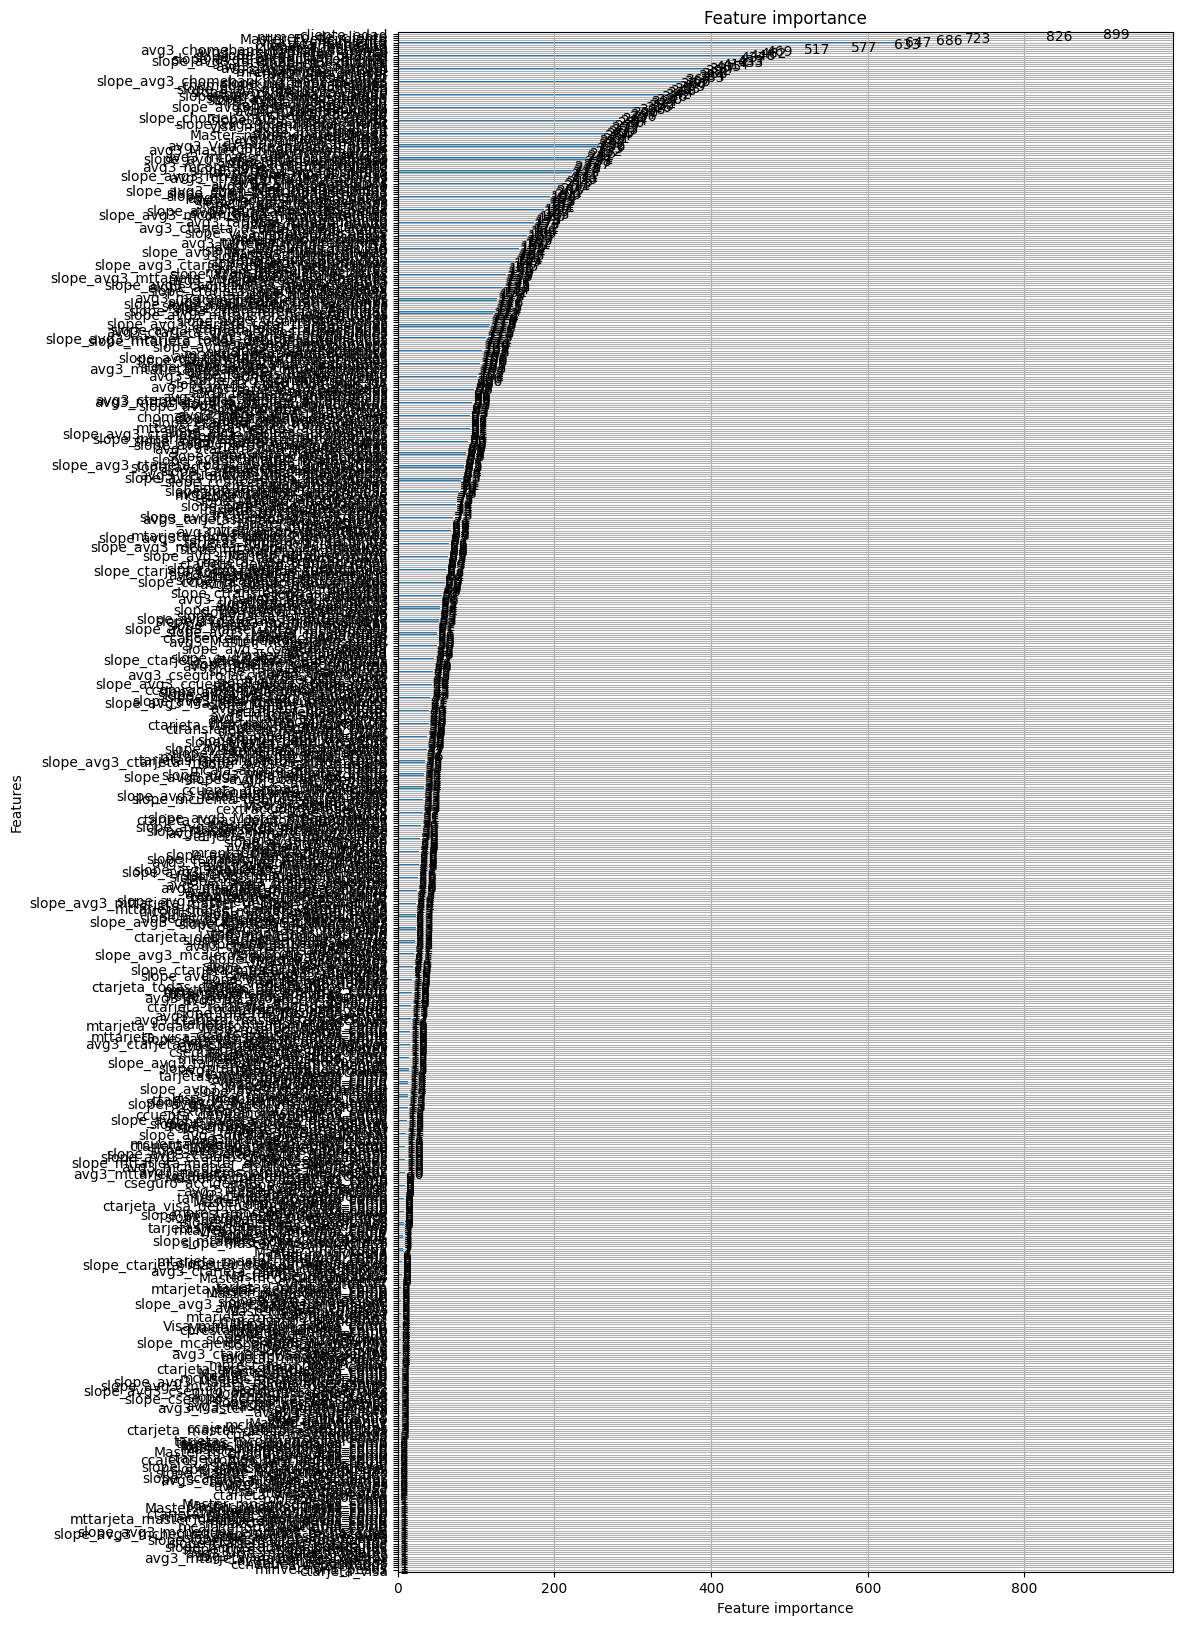

In [32]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [33]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


feature  importance
5                        cliente_edad         899
0                   numero_de_cliente         826
113               Master_Fvencimiento         723
135                 Visa_Fvencimiento         686
149                    Visa_fechaalta         647
..                                ...         ...
251   avg3_mtarjeta_master_descuentos           1
783  Master_mfinanciacion_limite_comp           1
816                        cc_ca_comp           1
786         Master_msaldodolares_comp           1
820                  mplazo_fijo_comp           1

[709 rows x 2 columns]

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [34]:
model.save_model(modelos_path + 'lgb_v002.txt')

# Punto de corte optimo

No me queda claro de si podemos hacer esto con los datos de train, o si tendria que volver a entrenar el modelo pero solo con los datos de febrero por ej y ver el punto de corte optimo estimando abril

In [45]:
y_pred_lgm = model.predict(X_train)

In [46]:
ganancia = np.where(y_train_binaria1 == 1, ganancia_acierto, 0) - np.where(y_train_binaria1 == 0, costo_estimulo, 0) # uso la binaria 1 porque es la que solo considera a los BAJA+2

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)

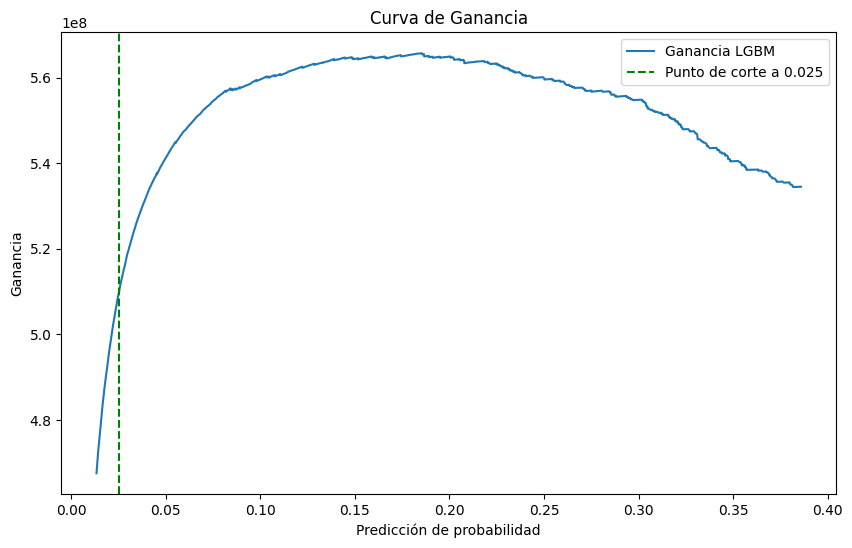

In [47]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

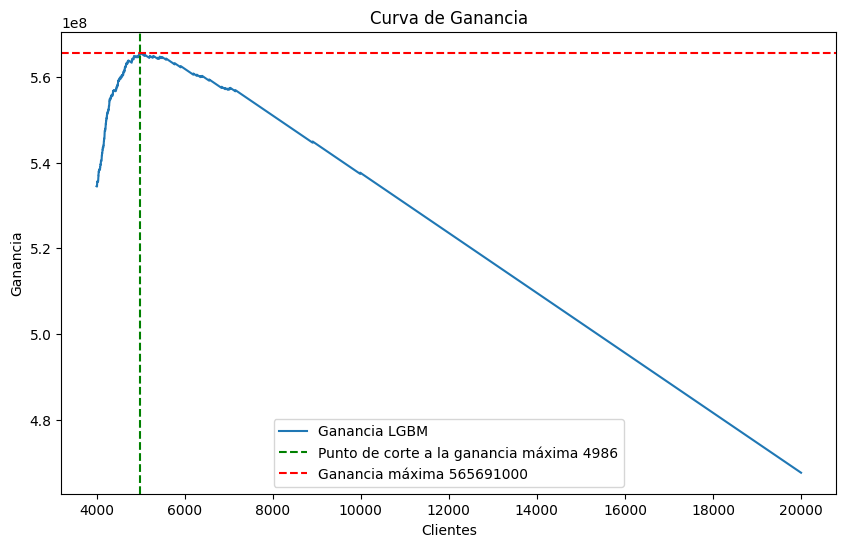

In [44]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

# Backtesting

Entreno con marzo y estimo para abril porque eran los unicos 2 meses para los cuales tengo todas las varibales temporales

In [61]:
train_data = data[data['foto_mes'] == 202103]
test_data = data[data['foto_mes'] == 202104]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Entrenamos el modelo solo con los datos de marzo

In [62]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

Mejor cantidad de árboles para el mejor model 557


In [63]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [64]:
params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'first_metric_only': True,
 'boost_from_average': True,
 'feature_pre_filter': False,
 'max_bin': 31,
 'num_leaves': 97,
 'learning_rate': 0.04683837088658049,
 'min_data_in_leaf': 683,
 'feature_fraction': 0.8181906690442271,
 'bagging_fraction': 0.8749388626750352,
 'seed': 122219,
 'verbose': 0}

In [65]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


obtenemos la predicción de **Abril**

In [66]:
y_pred_lgm = model.predict(X_test)

In [67]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


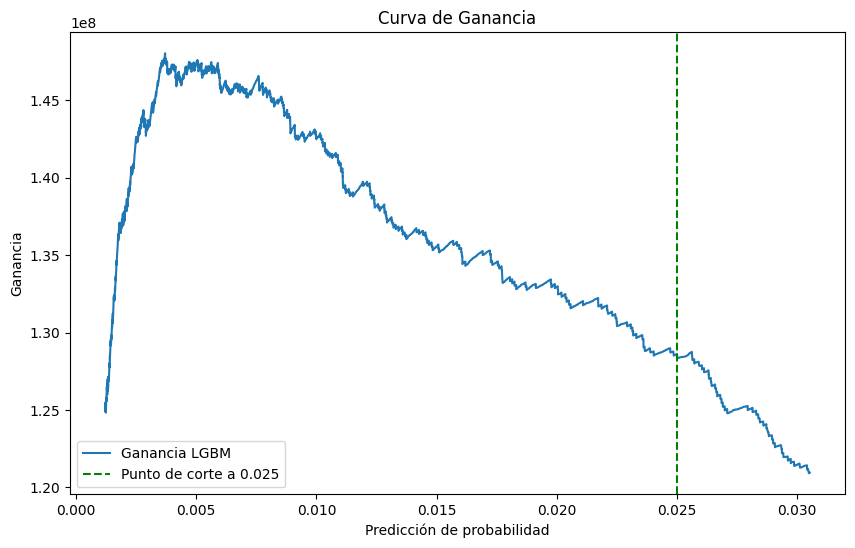

In [68]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


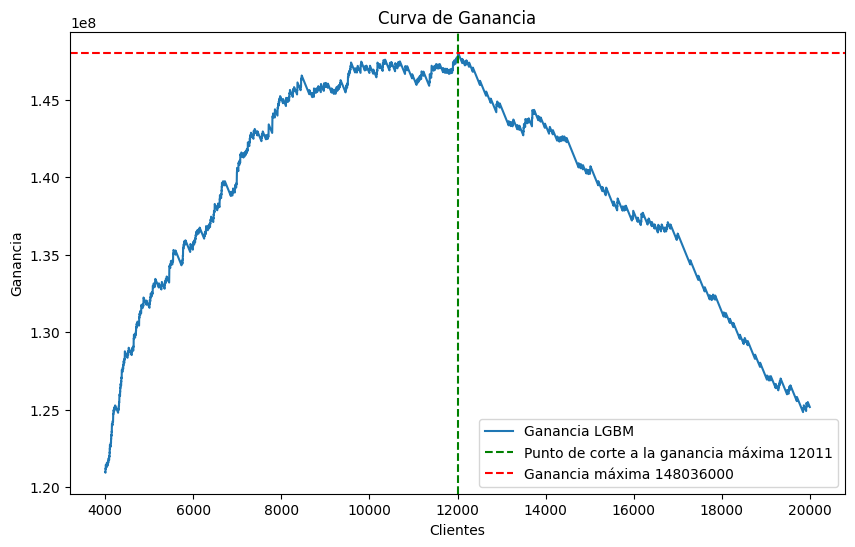

In [69]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


# Generar prediccion para Kaggle

Reentreno el modelo usando todos los meses que pueda

In [106]:
train_data = data[data['foto_mes'].isin([202103,202104])]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

In [107]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [108]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


In [109]:
future_data = data[data['foto_mes'] == 202106]

X_test = future_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

In [110]:
y_pred_lgm = model.predict(X_test)

# type(y_pred_lgm)
# y_pred_lgm.shape

In [111]:
X_test['pred_lgm'] = y_pred_lgm

In [112]:
# ordeno de mayor probabilidad de baja a menor

idx = np.argsort(y_pred_lgm)[::-1]
# idx[0:20]

X_test.reset_index(drop=True, inplace=True) # reseteo el index para poder ordenar por idx, sino en index tenia por default el numero de fila del dataframe original "data"
X_test = X_test.iloc[idx]

In [113]:
envios = np.zeros(len(X_test), dtype=int)
envios[:gan_max_idx] = 1

X_test['Predicted'] = envios

# otra forma:
# X_test['Predicted'] = 0
# X_test.loc[:gan_max_idx-1, 'Predicted'] = 1

In [114]:
output = X_test[['numero_de_cliente', 'Predicted']]

In [115]:
file_name = 'K101_005.csv'

output.to_csv(base_path + 'exp/KA2001/' + file_name, index=False)